<a href="https://colab.research.google.com/github/hui0041600/Flower-Image-Classifier/blob/main/flower_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

folder_path = '/content/drive/MyDrive/flowers'
print(os.listdir(folder_path))


['.DS_Store', 'rose', 'dandelion', 'sunflower', 'tulip', 'daisy']


In [3]:
# 2 Setting Directories for Different Flower Classes

IMG_SIZE = 224

daisy_dir = os.path.join(folder_path, 'daisy')
dandelion_dir = os.path.join(folder_path, 'dandelion')
roses_dir = os.path.join(folder_path, 'rose')
sunflowers_dir = os.path.join(folder_path, 'sunflower')
tulips_dir = os.path.join(folder_path, 'tulip')

print("Daisy directory:", daisy_dir)
print("Dandelion directory:", dandelion_dir)
print("Roses directory:", roses_dir)
print("Sunflowers directory:", sunflowers_dir)
print("Tulips directory:", tulips_dir)

Daisy directory: /content/drive/MyDrive/flowers/daisy
Dandelion directory: /content/drive/MyDrive/flowers/dandelion
Roses directory: /content/drive/MyDrive/flowers/rose
Sunflowers directory: /content/drive/MyDrive/flowers/sunflower
Tulips directory: /content/drive/MyDrive/flowers/tulip


In [4]:
# 3
import cv2
import numpy as np
import os

X = []
Z = []
def assign_label(img, flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in os.listdir(DIR):
        label = assign_label(img, flower_type)
        path = os.path.join(DIR, img)
        try:
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(np.array(img))
            Z.append(str(label))
        except Exception as e:
            pass

make_train_data('Daisy', daisy_dir)
make_train_data('Dandelion', dandelion_dir)
make_train_data('Rose', roses_dir)
make_train_data('Sunflower', sunflowers_dir)
make_train_data('Tulip', tulips_dir)


print(len(X))
print(len(Z))



4317
4317


In [5]:
# 4 The variable Z contains the labels as strings (e.g., 'Daisy', 'Rose', etc.). Using LabelEncoder to convert these string labels into numerical values.
# The labels are then converted into a one-hot encoded format using to_categorical().

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert labels to numerical values using LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Z)

# Convert numerical labels to one-hot encoded format
Y = to_categorical(Y, num_classes=len(le.classes_))

In [6]:
# 5. split into ‘training’ and ‘test’ dataset in 75/25 ratio

from sklearn.model_selection import train_test_split

# Assuming X and Y are your feature and label data respectively
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42) # 75/25 split

print("x_train shape:", np.array(x_train).shape)
print("y_train shape:", np.array(y_train).shape)
print("x_test shape:", np.array(x_test).shape)
print("y_test shape:", np.array(y_test).shape)

x_train shape: (3237, 224, 224, 3)
y_train shape: (3237, 5)
x_test shape: (1080, 224, 224, 3)
y_test shape: (1080, 5)


In [7]:
# 6. Load the pre-trained model:, ResNet50 using TensorFlow's Keras API, excluding the top (classification) layers.
# Add a new fully connected layer with the appropriate number of units for flower classification.
# Freeze the weights of the pre-trained layers to prevent them from being updated during training.

import tensorflow as tf

# Load the pre-trained ResNet50 model without the top layers
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model's layers
base_model.trainable = False

# Add a new classification head
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D
x = tf.keras.layers.Dense(512, activation='relu')(x) # Added a dense layer
predictions = tf.keras.layers.Dense(len(le.classes_), activation='softmax')(x) # Output layer with softmax

# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# 7. Train the model on the flower dataset by using 20 epochs
# Evaluate the model's performance on the validation set and fine-tune hyperparameters if necessary.

# Train the model
history = model.fit(np.array(x_train), np.array(y_train), epochs=20, validation_data=(np.array(x_test), np.array(y_test)))

# Evaluate the model
loss, accuracy = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 37s 226ms/step - accuracy: 0.6774 - loss: 1.1992 - val_accuracy: 0.8333 - val_loss: 0.4234
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - accuracy: 0.9153 - loss: 0.2598 - val_accuracy: 0.8889 - val_loss: 0.3268
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9412 - loss: 0.1672 - val_accuracy: 0.8574 - val_loss: 0.4402
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9578 - loss: 0.1170 - val_accuracy: 0.8806 - val_loss: 0.3890
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9868 - loss: 0.0565 - val_accuracy: 0.8815 - val_loss: 0.4031
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9910 - loss: 0.0373 - val_accuracy: 0.8806 - val_loss: 0.3620
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.9947 - loss: 0.0259 - val_accuracy: 0.8769 - val_loss: 0.4044
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.9971 - loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


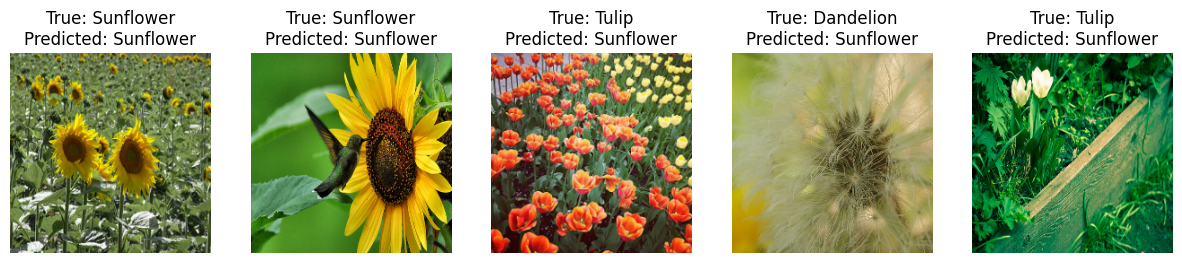

In [9]:
# 8
import random
import numpy as np
import matplotlib.pyplot as plt

# Function to display images with predictions
def display_images_with_predictions(num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        random_index = random.randint(0, len(x_test) - 1)
        image = x_test[random_index]
        true_label = np.argmax(y_test[random_index])

        # Ensure the image is in the correct format for prediction
        image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

        # Reshape the image to add a batch dimension
        image = np.expand_dims(image, axis=0)

        # Perform prediction using the TensorFlow model
        prediction = model.predict(image)
        predicted_label = np.argmax(prediction)

        axes[i].imshow(image[0]) # Display the image without the batch dimension
        axes[i].set_title(f"True: {le.classes_[true_label]}\nPredicted: {le.classes_[predicted_label]}")
        axes[i].axis('off')
    plt.show()

display_images_with_predictions()

 Implementing Transfer Learning in PyTorch

In [10]:
# 9. Load the pre-trained model :ResNet50 using PyTorch's ‘torchvision.models’.
# Replace the fully connected layer (classifier) with a new one suitable for flower classification.
# Freeze the weights of the pre-trained layers.

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# Load the pre-trained ResNet50 model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze the weights of the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Replace the fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 output classes for flowers

# Define a device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


In [11]:
# 10. Define a loss function: CrossEntropyLoss and an optimizer: Adam.
# Train the model on the flower dataset, similarly using a small number of epochs.
# Evaluate the model's performance on the validation set and adjust as needed.


from torch.utils.data import DataLoader, Dataset # Import DataLoader and Dataset
from PIL import Image # Import the Image module from Pillow

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001) # Optimize only the classifier's parameters

# Create a custom dataset class
class FlowerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx].astype('uint8')) # Ensure the data type is uint8
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create an instance of your dataset
train_dataset = FlowerDataset(x_train, y_train, transform=transform)

# Create an instance of your validation dataset using x_test and y_test
val_dataset = FlowerDataset(x_test, y_test, transform=transform)

# Create a DataLoader for your training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Create a DataLoader for your validation dataset
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [12]:
# 11. Train the model on the flower dataset, similarly using a small number of epochs.
# Evaluate the model's performance on the validation set and adjust as needed.

# Training loop
num_epochs = 20


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = torch.tensor(np.argmax(labels, axis=1)).to(device) # Convert one-hot encoded to class indices
        optimizer.zero_grad()

        # Change 'images' to 'inputs' here:
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = torch.tensor(np.argmax(labels, axis=1)).to(device)  # Convert to class indices
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

<ipython-input-12-dfa45fcf5501>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(np.argmax(labels, axis=1)).to(device) # Convert one-hot encoded to class indices


Epoch [1/20], Loss: 0.7031
Epoch [2/20], Loss: 0.4056
Epoch [3/20], Loss: 0.3562
Epoch [4/20], Loss: 0.3186
Epoch [5/20], Loss: 0.2906
Epoch [6/20], Loss: 0.2874
Epoch [7/20], Loss: 0.2748
Epoch [8/20], Loss: 0.2515
Epoch [9/20], Loss: 0.2420
Epoch [10/20], Loss: 0.2323
Epoch [11/20], Loss: 0.2243
Epoch [12/20], Loss: 0.2356
Epoch [13/20], Loss: 0.2327
Epoch [14/20], Loss: 0.2082
Epoch [15/20], Loss: 0.2071
Epoch [16/20], Loss: 0.2060
Epoch [17/20], Loss: 0.1941
Epoch [18/20], Loss: 0.2027
Epoch [19/20], Loss: 0.1938
Epoch [20/20], Loss: 0.1894


<ipython-input-12-dfa45fcf5501>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(np.argmax(labels, axis=1)).to(device)  # Convert to class indices


Validation Accuracy: 90.09%


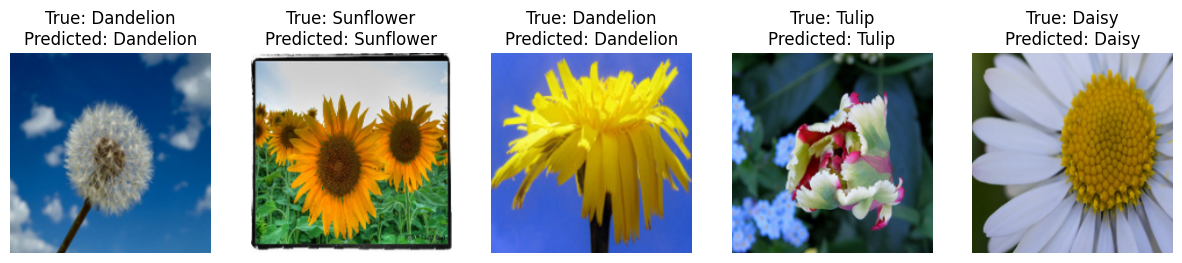

In [29]:
# Function to display images with predictions
def display_images_with_predictions(num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        random_index = random.randint(0, len(x_test) - 1)
        image = x_test[random_index]
        true_label = np.argmax(y_test[random_index])

        # Ensure the image is in the correct format for prediction
        image_tensor = transform(Image.fromarray(image.astype('uint8'))).unsqueeze(0).to(device)

        # Perform prediction using the PyTorch model
        with torch.no_grad():  # Disable gradient calculation during inference
            prediction = model(image_tensor)
        predicted_label = np.argmax(prediction.cpu().numpy()) # Get predicted class index

        # Denormalize the image for display
        image_display = image_tensor[0].cpu().permute(1, 2, 0).numpy()
        # Reverse the normalization process
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_display = std * image_display + mean
        image_display = np.clip(image_display, 0, 1)  # Clip values to [0, 1]

        axes[i].imshow(image_display)  # Display the denormalized image
        axes[i].set_title(f"True: {le.classes_[true_label]}\nPredicted: {le.classes_[predicted_label]}")
        axes[i].axis('off')
    plt.show()

display_images_with_predictions()